# Introduction:

This notebook uses [Scikit Learn](https://scikit-learn.org/stable/) to try out 3 different types of regression models to predict the price of that stock for a future date. As a former Accenture consultant many years ago I decided to use their stock price for the exercise instead of the typical popular tech companies used in many other examples. If you want to use another company just update the stock ticker symbol in the code below.

## Install Required Modules:

In [ ]:
# Make sure we have all the required modules imported into our environment

import sys
!{sys.executable} -m pip install -U pandas
!{sys.executable} -m pip install -U pandas_datareader
!{sys.executable} -m pip install -U matplotlib
!{sys.executable} -m pip install -U scikit-learn

## Read Stock Data Into Pandas From Yahoo Finance:

In [32]:
# Get the historic stock price data for the past 10 years from Yahoo finance

import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2009, 1, 1)
end = datetime.datetime(2019, 9, 8)

# Get NYSE:ACCENTURE share price from Yahoo finance
df = web.DataReader("ACN", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-30,200.679993,196.770004,200.000000,198.169998,2176600.0,198.169998
2019-09-03,197.759995,195.440002,196.360001,195.750000,1696500.0,195.750000
2019-09-04,198.360001,197.369995,197.830002,197.710007,1250700.0,197.710007
2019-09-05,199.800003,198.449997,199.800003,199.490005,2216100.0,199.490005
2019-09-06,202.800003,199.039993,200.000000,201.119995,2184100.0,201.119995


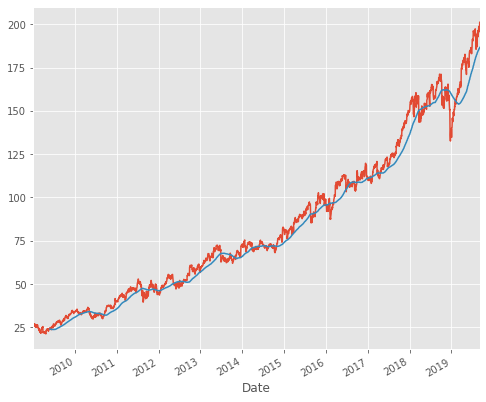

In [50]:
# Get the closing price and calculate the 100 day moving average as a new dataset:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

# Plot the actual closing price vs. the moving average
close_px.plot(label='ACN')
mavg.plot(label='mavg')
plt.show()

# Model Prediction

Now we have the data we can engineer the features we want to use to predict the stock price and train our machine learning models against them. For this exercise 3 models will be compared from Scikit:

* Simple Linear Analysis
* Quadratic Linear Analysis (QDA)
* K Nearest Neighbor (KNN)

## Feature Engineering:

In [33]:
# Feature Engineering: 
# Create a new dataframe with the following features: 
# Adjusted Close, Trading Volume, High/Low Percentage, Percentage Change

dfreg = df.loc[:,["Adj Close","Volume"]]
dfreg["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dfreg["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-30,198.169998,2176600.0,1.973048,-0.915001
2019-09-03,195.750000,1696500.0,1.185181,-0.310654
2019-09-04,197.710007,1250700.0,0.500736,-0.060656
2019-09-05,199.490005,2216100.0,0.676729,-0.155154
2019-09-06,201.119995,2184100.0,1.869536,0.559998


## Pre-Processing The Data:

To avoid overfitting of the model to the data, we cannot use the same training data to test the model during iterations. Therefore we split the training data into 2 parts: the first 90% of the data will be used as the input training data, and the last 10% of the data will be used for testing the model.

Read more at [https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6).

In [36]:
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, svm

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 10 percent of the data to forecast
forecast_out = int(math.ceil(0.1 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Dimension of X (2419, 4)
Dimension of y (2419,)


## 1. Linear Regression Model Results:

The linear regression confidence is 96.03185176676305%
X_lately = [[ 1.61188518 -0.54183793 -0.57126645 -0.39145713]
 [ 1.6336379  -0.37695473 -0.65314467  0.53428048]
 [ 1.61576204 -0.51532152 -0.68767698 -0.1957207 ]
 ...
 [ 2.49361568 -0.65532679 -1.28087318 -0.16625742]
 [ 2.53262297 -0.33251551 -1.08987251 -0.25123687]
 [ 2.56834293 -0.3432157   0.20465342  0.39187739]]
Last Date = 2010-01-28 00:00:00


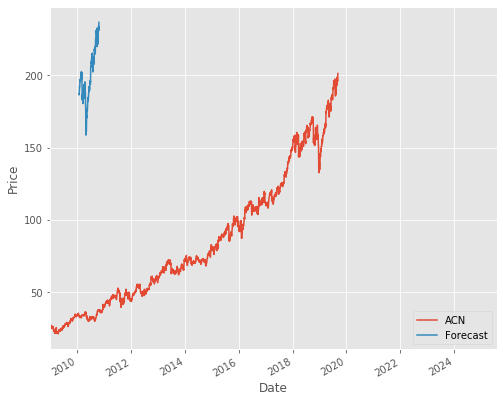

In [56]:
from sklearn.linear_model import LinearRegression

# Train the model
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

confidencereg = clfreg.score(X_test, y_test) * 100
print(f"The linear regression confidence is {confidencereg}%")

# Make a prediction
forecast_set = clfreg.predict(X_lately)
print(f"X_lately = {X_lately}")
dfreg['Forecast'] = np.nan

# Plot the prediction
last_date = dfreg.iloc[forecast_out].name
print(f"Last Date = {last_date}")
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
close_px.plot(label='ACN')
dfreg['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## 2. Quadratic Linear Analysis (QDA) Results:

The quadratic regression 2 confidence is 96.10887430210538%


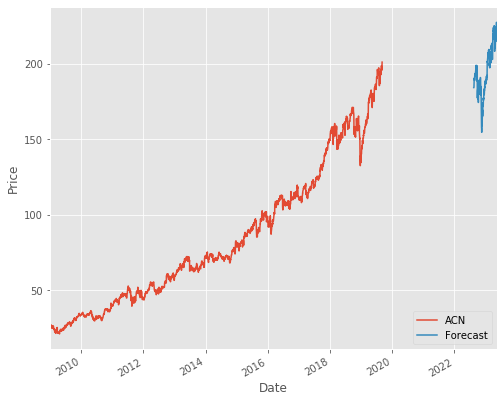

In [47]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Train the model
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

confidencepoly2 = clfpoly2.score(X_test,y_test) * 100
print(f"The quadratic regression 2 confidence is {confidencepoly2}%")

# Make a prediction
forecast_set = clfpoly2.predict(X_lately)
dfreg['Forecast'] = np.nan

# Plot the prediction
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
close_px.plot(label='ACN')
dfreg['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## 3. K Nearest Neighbor (KNN) Results:

The knn regression confidence is 94.21050177925467%


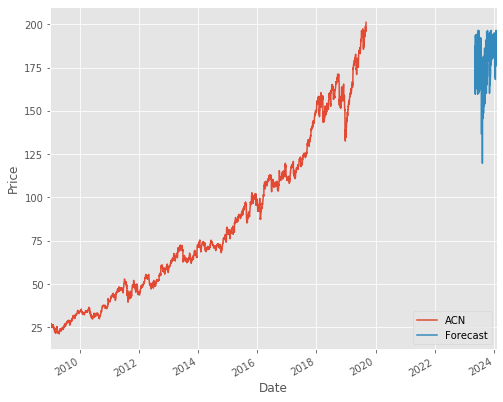

In [49]:
from sklearn.neighbors import KNeighborsRegressor

# Train the model
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

confidenceknn = clfknn.score(X_test, y_test) * 100
print(f"The knn regression confidence is {confidenceknn}%")

# Make a prediction
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

# Plot the prediction
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
close_px.plot(label='ACN')
dfreg['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Conclusion

The Quadratic Linear Model (QDA) has the highest confidence with our test data.